<a href="https://colab.research.google.com/github/luisfucros/Projects/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import cv2
from random import shuffle
import os
import bz2
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisfucros","key":"029176aa2bff05b4aa9c6cbfad6fca9f"}'}

In [3]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ymanojkumar023/kumarmanoj-bag-of-words-meets-bags-of-popcorn

 93% 49.0M/52.4M [00:01<00:00, 18.3MB/s]
100% 52.4M/52.4M [00:01<00:00, 30.2MB/s]


In [5]:
!kaggle datasets download -d utathya/imdb-review-dataset

 65% 33.0M/50.5M [00:01<00:01, 12.0MB/s]
100% 50.5M/50.5M [00:01<00:00, 32.8MB/s]


In [6]:
!ls

imdb-review-dataset.zip  kumarmanoj-bag-of-words-meets-bags-of-popcorn.zip
kaggle.json		 sample_data


In [7]:
!unzip  kumarmanoj-bag-of-words-meets-bags-of-popcorn.zip

Archive:  kumarmanoj-bag-of-words-meets-bags-of-popcorn.zip
  inflating: labeledTrainData.tsv    
  inflating: sampleSubmission.csv    
  inflating: testData.tsv            
  inflating: unlabeledTrainData.tsv  


In [8]:
!unzip imdb-review-dataset.zip	

Archive:  imdb-review-dataset.zip
  inflating: imdb_master.csv         


In [2]:
df1 = pd.read_csv('labeledTrainData.tsv',delimiter='\t',quoting=3)
df1.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [3]:
df1 = df1.iloc[:,1:]
df1.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  25000 non-null  int64 
 1   review     25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [5]:
df1.sentiment.value_counts()

1    12500
0    12500
Name: sentiment, dtype: int64

In [6]:
df2 = pd.read_csv('imdb_master.csv', encoding = 'ISO-8859-1')
df2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [7]:
df2 = df2.iloc[:,[2,3]]
df2.head()

,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   review  100000 non-null  object
 1   label   100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [9]:
df2.columns = ['review', 'sentiment']
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [10]:
df2.sentiment.unique()

array(['neg', 'pos', 'unsup'], dtype=object)

In [11]:
df2 = df2[df2.sentiment!='unsup']
df2['sentiment'] = df2['sentiment'].map({'pos':1,'neg':0})
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [12]:
df2.sentiment.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [13]:
df = pd.concat([df1,df2]).reset_index(drop=True)
df.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [14]:
df.sentiment.value_counts()

1    37500
0    37500
Name: sentiment, dtype: int64

In [15]:
#Remove HTML tags
from bs4 import BeautifulSoup
BeautifulSoup(df['review'][0]).get_text()

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 2

In [16]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmanizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def preprocessing_text(text):
  text = re.sub('[^A-Za-z0-9]',' ', text)
  text = text.lower()
  text = [lemmanizer.lemmatize(token) for token in text.split(' ')]
  #text = [lemmanizer.lemmatize(token,'v') for token in text]
  text = [word for word in text if word not in stop_words]
  text = ' '.join(text)
  return text

In [18]:
nltk.download('wordnet')
df['preprocessed_text'] = df.review.apply(lambda x : preprocessing_text(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [19]:
df.head()

,sentiment,review,preprocessed_text
0,1,"""With all this stuff going down at the moment ...",stuff going moment mj started listening music...
1,1,"""\""The Classic War of the Worlds\"" by Timothy ...",classic war world timothy hines entertain...
2,0,"""The film starts with a manager (Nicholas Bell...",film start manager nicholas bell giving wel...
3,0,"""It must be assumed that those who praised thi...",must assumed praised film greatest filmed ...
4,1,"""Superbly trashy and wondrously unpretentious ...",superbly trashy wondrously unpretentious 80 e...


In [20]:
df.preprocessed_text.apply(lambda x : len(x.split(' '))).mean()

173.10122666666666

In [21]:
max_features = 80000

tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(df['preprocessed_text'])
train_tok = tokenizer.texts_to_sequences(df['preprocessed_text'])

In [24]:
len(tokenizer.word_index)

91522

In [25]:
tokenizer.word_index['<OOV>']

1

In [26]:
print(train_tok[0])

[408, 82, 151, 9345, 533, 2428, 121, 69, 900, 450, 195, 19364, 195, 13334, 181, 64, 14, 653, 1923, 70, 95, 4, 18, 495, 3140, 181, 16, 202, 604, 2245, 1164, 13334, 59, 3939, 59, 343, 5, 280, 82, 17, 313, 4, 1711, 505, 8, 1161, 536, 9345, 316, 811, 3141, 25, 477, 536, 627, 22, 4670, 2, 2, 1920, 1040, 175, 375, 1417, 769, 2419, 7, 9345, 436, 82, 559, 62, 257, 110, 400, 9345, 27959, 25955, 135, 3, 9345, 111, 15, 45, 30, 111, 191, 18, 234, 2, 2, 671, 343, 5, 113, 318, 142, 683, 91, 14786, 3596, 1081, 304, 790, 9537, 958, 10923, 829, 627, 1392, 64, 9345, 250, 22, 566, 9345, 17585, 817, 13670, 790, 9537, 11, 30495, 359, 23, 35, 16484, 627, 402, 9473, 181, 559, 9345, 121, 2, 2, 66, 495, 29, 7, 9345, 1447, 326, 1560, 128, 1844, 1266, 304, 25, 61, 116, 4475, 3671, 283, 1261, 9538, 22, 304, 517, 61, 559, 629, 6, 130, 153, 497, 128, 630, 3167, 1175, 631, 20, 2, 2, 1145, 109, 3, 23, 7, 9345, 6, 412, 77, 33, 23, 524, 149, 53, 129, 65, 7043, 536, 3303, 9345, 33814, 1270, 3, 85, 375, 1417, 269, 6, 895

In [27]:
l = []
for i in train_tok:
  l.append(len(i))
np.mean(l)  

126.90241333333333

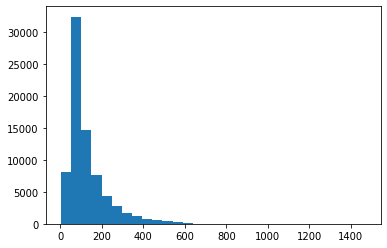

In [28]:
plt.hist(l,bins=30)
plt.show()

In [29]:
max_len = 130

X_train = keras.preprocessing.sequence.pad_sequences(train_tok,maxlen=max_len)
y_train = df['sentiment'].values.reshape(-1)

In [42]:
word_index = {v:k for k,v in tokenizer.index_word.items()}

In [36]:
print([tokenizer.index_word[num] for num in train_tok[0]])

['stuff', 'going', 'moment', 'mj', 'started', 'listening', 'music', 'watching', 'odd', 'documentary', 'watched', 'wiz', 'watched', 'moonwalker', 'maybe', 'want', 'get', 'certain', 'insight', 'guy', 'thought', 'wa', 'really', 'cool', 'eighty', 'maybe', 'make', 'mind', 'whether', 'guilty', 'innocent', 'moonwalker', 'part', 'biography', 'part', 'feature', 'film', 'remember', 'going', 'see', 'cinema', 'wa', 'originally', 'released', 'ha', 'subtle', 'message', 'mj', 'feeling', 'towards', 'press', 'also', 'obvious', 'message', 'drug', 'bad', 'kay', 'br', 'br', 'visually', 'impressive', 'course', 'michael', 'jackson', 'unless', 'remotely', 'like', 'mj', 'anyway', 'going', 'hate', 'find', 'boring', 'may', 'call', 'mj', 'egotist', 'consenting', 'making', 'movie', 'mj', 'fan', 'would', 'say', 'made', 'fan', 'true', 'really', 'nice', 'br', 'br', 'actual', 'feature', 'film', 'bit', 'finally', 'start', '20', 'minute', 'excluding', 'smooth', 'criminal', 'sequence', 'joe', 'pesci', 'convincing', 'psy

In [37]:
embed_size = 128
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=max_features+1,output_dim=embed_size))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(20,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         10240128  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          41216     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
batch_normalization (BatchNo (None, 20)                80        
_________________________________________________________________
dropout (Dropout)            (None, 20)                0

In [38]:
learning_rate = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.1,min_lr=0.00001)
modelcheck = ModelCheckpoint('Sentiment_analysis.hdf5',monitor='val_accuracy',mode='max',save_best_only=True)

In [39]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
history = model.fit(X_train,y_train,
                    batch_size=128, epochs=30,
                    callbacks=[learning_rate,modelcheck],validation_split=0.25)

Epoch 1/30
440/440 [==============================] - 63s 142ms/step - loss: 0.2971 - accuracy: 0.8758 - val_loss: 0.1456 - val_accuracy: 0.9537 - lr: 0.0010
Epoch 2/30
440/440 [==============================] - 60s 137ms/step - loss: 0.1456 - accuracy: 0.9475 - val_loss: 0.0767 - val_accuracy: 0.9761 - lr: 0.0010
Epoch 3/30
440/440 [==============================] - 60s 136ms/step - loss: 0.0787 - accuracy: 0.9727 - val_loss: 0.0429 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 4/30
440/440 [==============================] - 60s 135ms/step - loss: 0.0441 - accuracy: 0.9853 - val_loss: 0.0218 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 5/30
440/440 [==============================] - 59s 133ms/step - loss: 0.0361 - accuracy: 0.9882 - val_loss: 0.0149 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 6/30
440/440 [==============================] - 59s 133ms/step - loss: 0.0200 - accuracy: 0.9936 - val_loss: 0.0101 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 7/30
440/440 [==============================] 

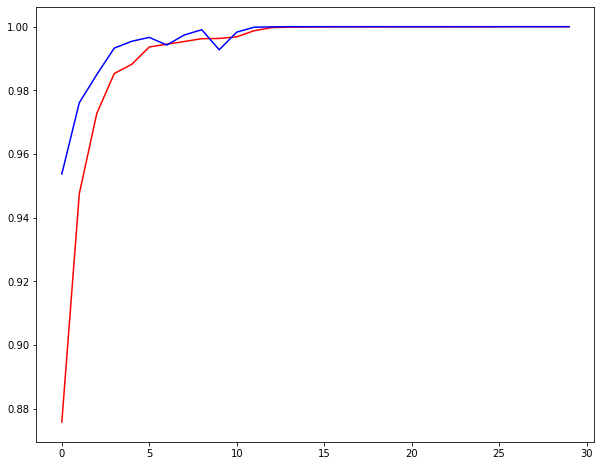

In [41]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'],'r',history.history['val_accuracy'],'b')
plt.show()

In [43]:
word_index['<OOV>']

1

In [44]:
def review_encode(text):
  text = preprocessing_text(text)
  #text = ' '.join(text.split())
  tokens = keras.preprocessing.text.text_to_word_sequence(text)
  tokens = [tokenizer.word_index[word] if word in word_index else 1 for word in tokens]
  tokens = keras.preprocessing.sequence.pad_sequences([tokens],maxlen=max_len)[0]
  return tokens.reshape(1,130)

In [63]:
print(review_encode('the movie was great, the director did a good job producing such an excellent movie'))

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    3    4   24   61   10
   179 3693  223    3]]


In [67]:
def predictor(text):
  encoded_text = review_encode(text)
  pred = np.zeros((1,130))
  pred[0] = encoded_text
  result = model.predict(pred)[0][0]
  return result
positive_review='That movie was so awesome! I really loved it and would watch it again because iwas amazingly great'
print(predictor(positive_review))
negative_review="That movie sucked. I hated it  and wouldn't watch it again. Was one of the worst things I've ever watched"
print(predictor(negative_review) ) 

0.99997854
7.114091e-06


In [86]:
user_input = input('Review of the movie: ')
print('Probability of being a positive review: {}'.format(predictor(user_input)))

Review of the movie: If you are among the few who haven't seen it yet: believe the hype, it really is THAT good. Breaking Bad may not depict reality the way 'Generation Kill' or 'The Wire' did - but then it's not about that, either. From an artistic point of view - performances, writing, direction, camera, music - this show is every bit as good as the other two mentioned above, but unlike those, 'Breaking Bad' just wants to entertain and therefore enjoys a lot more creative freedom.  The show plays like the daydream fantasy of any underachieving, struggling middle class family man who's had to bury all his dreams (I mean: who wouldn't want to be a meth-kingpin for a little while?), before it turns into a nightmare. One could almost say that 'Heisenberg' is Walter White's 'Tyler Durden'(for those who don't get the reference: watch 'Fight Club' - you won't regret it).  For pure entertainment value, this is simply the best show I've ever seen. Every single one of the main characters has a

In [71]:
data_test = pd.read_csv('testData.tsv',delimiter='\t')
data_test.head()

,id,review
0,12311_10,Naturally in a film who's main themes are of m...
1,8348_2,This movie is a disaster within a disaster fil...
2,5828_4,"All in all, this is a movie for kids. We saw i..."
3,7186_2,Afraid of the Dark left me with the impression...
4,12128_7,A very accurate depiction of small time mob li...


In [72]:
test_text = pd.read_csv('testData.tsv',delimiter='\t')
test_text.iloc[5,1]

"...as valuable as King Tut's tomb! (OK, maybe not THAT valuable, but worth hunting down if you can). I notice no one has commented on this movie for some years, and I hope a fresh post will spark some new comments. This is a film that I remembered only snippets of from childhood, and only saw recently when I tired of waiting for Fox to honour its own past, and hunted down the Korean DVD (in English, but with unremovable Korean subtitles). I won't go through another long plot description - suffice to say that seeing it for the first time in its proper widescreen format left me agape at the vistas and the scope of the film. The matte paintings still hold up, and the palace sets are truly breathtaking. But it is the smaller scale details that lend this film its depth and richness, offering a glimpse into the lifestyles of Egypt's poor as well as its elite. The bazaars, hovels, docks, embalming houses, and taverns are as fascinating as Pharaoh's throne room. While errors abound on the lar

In [74]:
data_test['review'] = data_test.review.apply(lambda x : preprocessing_text(x))

In [75]:
X_t = tokenizer.texts_to_sequences(data_test['review'])
X_test = keras.preprocessing.sequence.pad_sequences(X_t,maxlen=max_len)

In [76]:
model.predict(X_test[0:10])

array([[1.0000000e+00],
       [1.4841629e-06],
       [2.4773433e-06],
       [6.7454521e-06],
       [9.9999964e-01],
       [1.0000000e+00],
       [8.1769294e-06],
       [9.1529846e-06],
       [3.8556720e-07],
       [9.9998140e-01]], dtype=float32)

In [ ]:
" ".join([index_word[num] for num in X_test[0] if num!=0])

'naturally film main theme nostalgia loss innocence perhaps surprise rat highly older viewer younger one however film anyone enjoy pace steady constant character full engage relationship interaction natural show need flood tear show emotion scream show fear shout show violence show anger naturally short story lend film ready make structure perfect polish diamond small change huston make inclusion poem fit neatly truly masterpiece subtlety overwhelm beauty'

In [ ]:
data_test.iloc[1,1]

'movie disaster within disaster film full great action scene meaningful throw away sense reality let see word wise lava burn steam burn cant stand next lava divert minor lava flow difficult let alone significant one scare think might actually believe saw moviebr br even worse significant amount talent go make film mean act actually good effect average hard believe somebody read script allow talent waste guess suggestion would movie start tv  look away like train wreck awful know come watch look away spend time meaningful content'

In [77]:
preds=model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [78]:
preds.shape

(25000, 1)

In [79]:
sub_data=pd.read_csv('sampleSubmission.csv')
sub_data.head()

,id,sentiment
0,12311_10,0
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,0


In [80]:
sub_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [81]:
sub_data['sentiment']=preds

In [82]:
sub_data.head()

,id,sentiment
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [83]:
sub_data.to_csv('submission.csv',index=False)

In [84]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
files.download('Sentiment_analysis.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>